In [1]:
import numpy as np
from keras.models import Model, Sequential, model_from_json
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, ActivityRegularization, Lambda, Concatenate, Permute, Convolution1D, MaxPooling1D, AveragePooling1D, GlobalAveragePooling1D
from keras.layers.merge import _Merge, concatenate
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from keras.datasets import mnist
from keras import backend as K
from keras import regularizers
from functools import partial
import matplotlib.pyplot as plt
from matplotlib import colors as mcol

import pylab as py
# from tools import load, save, checkdir
import pandas as pd
from matplotlib.lines import Line2D

Using TensorFlow backend.


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="3"
imagedir = './'

In [3]:
def dot(A,B):
    return A[0]*B[0] - A[1]*B[1] - A[2]*B[2] - A[3]*B[3]

In [4]:
def gamma_dist_rand(N):
    y = np.random.choice(np.arange(0, 10000), size = N, p = gamma_hist)
    y = gamma_min + (y + np.random.uniform(0, 1, N))*(gamma_max - gamma_min)/10000
    
    return(y)

In [5]:
pmass = 0.93827
pipmass = 0.1395
pimmass = 0.1395

In [6]:
epsilon = 0.001

In [7]:
datapath = "../../evts-clas.npy"
events = np.load(datapath)

In [8]:
px = events[:, 2]
py = events[:, 5]
ptheta = np.arctan2(py, px)
ptheta = ptheta.reshape(-1, 1)

pipx = events[:, 3]
pipy = events[:, 6]
piptheta = np.arctan2(pipy, pipx)
piptheta = piptheta.reshape(-1, 1)

theta = np.concatenate([ptheta, piptheta], axis=1)
theta = np.floor(theta/np.pi*180+205)%60

index = np.where((theta[:, 0]<=50)&(theta[:, 1]<=50))

events = events[index]

In [9]:
events.shape

(2507253, 14)

In [10]:
M2pi = events[:, 0]
gamma = events[:, 1]
px = events[:, 2]
py = events[:, 5]
pz = events[:, 8]
pe = events[:, 11]
pipx = events[:, 3]
pipy = events[:, 6]
pipz = events[:, 9]
pipe = events[:, 12]
pimx = events[:, 4]
pimy = events[:, 7]
pimz = events[:, 10]
# pime = events[:, 13]

pt = np.sqrt(px*px + py*py)
pzt = pz/(pt+epsilon)
pipt = np.sqrt(pipx*pipx + pipy*pipy)
pipzt = pipz/(pipt+epsilon)
pimt = np.sqrt(pimx*pimx + pimy*pimy)
pimzt = pimz/(pimt+epsilon)

pipphi = np.arctan2( pipy , pipx )
pipphi = np.where(pipphi < 0, pipphi + 2 * np.pi, pipphi)

pime = gamma + pmass - pe - pipe
p = np.stack([pe, px, py, pz], axis=1)
pip = np.stack([pipe, pipx, pipy, pipz], axis=1)
pim = np.stack([pime, pimx, pimy, pimz], axis=1)
ppip = p*pip
ppim = p*pim
pippim = pip*pim

In [11]:
s  = 2*gamma*pmass + pmass*pmass
s1 = (pipe+pime)*(pipe+pime)-(pipx+pimx)*(pipx+pimx)-(pipy+pimy)*(pipy+pimy)-(pipz+pimz)*(pipz+pimz)
s2 = (pe+pime)*(pe+pime)-(px+pimx)*(px+pimx)-(py+pimy)*(py+pimy)-(pz+pimz)*(pz+pimz)

t1   = (pmass - pipe)*(pmass - pipe) - pipx * pipx - pipy * pipy - pipz * pipz
m2pi = pime * pime - pimx * pimx - pimy * pimy - pimz * pimz
mpx2 = (gamma + pmass - pe)*(gamma + pmass - pe) - px * px - py * py - (gamma - pz) * (gamma - pz)
mmpm2pi = mpx2 * m2pi

In [12]:
# Lorentz boost parameters
v0 = gamma + pmass
v3 = gamma

v0prime = np.sqrt( v0*v0 - v3*v3 )

cL = v0/v0prime
sL = -v3/v0prime

pzcms = sL * pe + cL * pz
pipzcms = sL * pipe + cL * pipz
pimzcms = sL * pime + cL * pimz

In [13]:
n1 = 1 / np.sqrt( px*px + py*py + pzcms*pzcms )
upp = np.stack([px*n1, py*n1, pzcms*n1], axis=1)

n2 = 1 / np.sqrt( pipx*pipx + pipy*pipy + pipzcms*pipzcms )
upip = np.stack([pipx*n2, pipy*n2, pipzcms*n2], axis=1)

n3 = 1 / np.sqrt( pimx*pimx + pimy*pimy + pimzcms*pimzcms )
upim = np.stack([pimx*n3, pimy*n3, pimzcms*n3], axis=1)

In [14]:
nz0 = np.array( [ np.zeros( np.shape( upip )[0] ),
       np.zeros( np.shape( upip )[0] ),
       -np.ones( np.shape( upip )[0] ) ] )

nz = nz0.T
nz_dot_u1 = nz[:,0]*upip[:,0] + nz[:,1]*upip[:,1] + nz[:,2]*upip[:,2]
u2_dot_u1 = upim[:,0]*upip[:,0] + upim[:,1]*upip[:,1] + upim[:,2]*upip[:,2]

In [15]:
#alpha[pi+p'][pi-p] calc

ag1 = 1/np.sqrt( 1 - nz_dot_u1*nz_dot_u1 )
ag = np.array( [ag1] * 3 ).T
bg1 = - nz_dot_u1 * ag1
bg = np.array( [bg1] * 3 ).T
ugamma = ag * nz + bg * upip

In [16]:
ab1 = 1/np.sqrt( 1 - u2_dot_u1*u2_dot_u1 )
ab = np.array( [ab1] * 3 ).T
bb1 = - u2_dot_u1 * ab1
bb = np.array( [bb1] * 3 ).T
ubeta = ab * upim + bb * upip

delta = np.array( [ ugamma[:,1] * ubeta[:,2] - ugamma[:,2] * ubeta[:,1],
                   ugamma[:,2] * ubeta[:,0] - ugamma[:,0] * ubeta[:,2],
                   ugamma[:,0] * ubeta[:,1] - ugamma[:,1] * ubeta[:,0] ] ).T

n4 = 1 / np.sqrt( delta[:,0]*delta[:,0] + delta[:,1]*delta[:,1] + delta[:,2]*delta[:,2] )
udelta = np.stack( [ delta[:,0]*n4, delta[:,1]*n4, delta[:,2]*n4 ] )

In [17]:
cosine = ugamma[:,0]*ubeta[:,0] + ugamma[:,1]*ubeta[:,1] + ugamma[:,2]*ubeta[:,2]
colinearity = upip[:,0]*udelta[0,:] + upip[:,1]*udelta[1,:] + upip[:,2]*udelta[2,:]

alpha = np.where(colinearity > 0.999999, np.arccos( cosine ) * 180 / np.pi,
                  ( 2 * np.pi - np.arccos( cosine ) ) * 180 / np.pi )

In [18]:
phialpha = pipphi * alpha

In [19]:
gamma_dist = s
gamma_min = np.min(gamma_dist)
gamma_max = np.max(gamma_dist)
[gamma_hist, gamma_edges] = np.histogram(gamma_dist, bins = 10000, range=[gamma_min, gamma_max])

In [20]:
gamma_min

6.512070253506

In [21]:
gamma_max

8.080279156224

In [22]:
gamma_hist = gamma_hist/gamma_dist.shape[0]
np.save('gamma_hist.npy', gamma_hist)

In [23]:
clas_origin = np.stack([ s, s1, s2, t1, pipphi, alpha, m2pi, mpx2, mmpm2pi, phialpha ], axis = 1)

In [24]:
index = np.where(clas_origin[:, 6]>-0.15)
clas_cut = clas_origin[index]
MMP_cut = mpx2[index]

In [25]:
# normalization
clasmean = np.mean(clas_origin, axis = 0)
classtd = np.std(clas_origin, axis = 0)
clas = (clas_origin - clasmean)/classtd
gfeaturesmean = clasmean[0:8]
gfeaturesstd = classtd[0:8]
gammamean = clasmean[0:1]
gammastd = classtd[0:1]
mmpm2pimean = clasmean[8:9]
mmpm2pistd = classtd[8:9]
phialphamean = clasmean[9:10]
phialphastd = classtd[9:10]

In [26]:
np.save('gfeaturesmean.npy', gfeaturesmean)
np.save('gfeaturesstd.npy', gfeaturesstd)

In [27]:
np.shape( gfeaturesmean )

(8,)

In [28]:
np.shape( gfeaturesstd )

(8,)

In [29]:
np.shape( clas )

(2507253, 10)

In [30]:
HALF_BATCH = 12000
BATCH_SIZE = HALF_BATCH * 2
# The training ratio is the number of discriminator updates
# per generator update. The paper uses 5.
TRAINING_RATIO = 5
GRADIENT_PENALTY_WEIGHT = 10  # As per the paper

In [31]:
def MMD_loss(x, y):
    sigma = 0.1
    x1 = x[:HALF_BATCH, :]
    x2 = x[HALF_BATCH:, :]
    y1 = y[:HALF_BATCH, :]
    y2 = y[HALF_BATCH:, :]
#     x1_x2 = K.sum(K.exp(-(x1-x2)*(x1-x2)/sigma))/HALF_BATCH
#     y1_y2 = K.sum(K.exp(-(y1-y2)*(y1-y2)/sigma))/HALF_BATCH
#     x_y = K.sum(K.exp(-(x-y)*(x-y)/sigma))/BATCH_SIZE
    
    x1_x2 = K.sum(K.exp(sigma/((x1-x2)*(x1-x2)+sigma)))/HALF_BATCH
    y1_y2 = K.sum(K.exp(sigma/((y1-y2)*(y1-y2)+sigma)))/HALF_BATCH
    x_y = K.sum(K.exp(sigma/((x-y)*(x-y)+sigma)))/BATCH_SIZE
    
    return (x1_x2 + y1_y2 - 2*x_y)*(x1_x2 + y1_y2 - 2*x_y)

In [32]:
def wasserstein_loss(y_true, y_pred):
    """Calculates the Wasserstein loss for a sample batch.
    The Wasserstein loss function is very simple to calculate. In a standard GAN, the
    discriminator has a sigmoid output, representing the probability that samples are
    real or generated. In Wasserstein GANs, however, the output is linear with no
    activation function! Instead of being constrained to [0, 1], the discriminator wants
    to make the distance between its output for real and generated samples as
    large as possible.
    The most natural way to achieve this is to label generated samples -1 and real
    samples 1, instead of the 0 and 1 used in normal GANs, so that multiplying the
    outputs by the labels will give you the loss immediately.
    Note that the nature of this loss means that it can be (and frequently will be)
    less than 0."""
    return K.mean(y_true * y_pred)

In [33]:
def gradient_penalty_loss(y_true, y_pred, averaged_samples,
                          gradient_penalty_weight):
    """Calculates the gradient penalty loss for a batch of "averaged" samples.
    In Improved WGANs, the 1-Lipschitz constraint is enforced by adding a term to the
    loss function that penalizes the network if the gradient norm moves away from 1.
    However, it is impossible to evaluate this function at all points in the input
    space. The compromise used in the paper is to choose random points on the lines
    between real and generated samples, and check the gradients at these points. Note
    that it is the gradient w.r.t. the input averaged samples, not the weights of the
    discriminator, that we're penalizing!
    In order to evaluate the gradients, we must first run samples through the generator
    and evaluate the loss. Then we get the gradients of the discriminator w.r.t. the
    input averaged samples. The l2 norm and penalty can then be calculated for this
    gradient.
    Note that this loss function requires the original averaged samples as input, but
    Keras only supports passing y_true and y_pred to loss functions. To get around this,
    we make a partial() of the function with the averaged_samples argument, and use that
    for model training."""
    # first get the gradients:
    #   assuming: - that y_pred has dimensions (batch_size, 1)
    #             - averaged_samples has dimensions (batch_size, nbr_features)
    # gradients afterwards has dimension (batch_size, nbr_features), basically
    # a list of nbr_features-dimensional gradient vectors
    gradients = K.gradients(y_pred, averaged_samples)[0]
    # compute the euclidean norm by squaring ...
    gradients_sqr = K.square(gradients)
    #   ... summing over the rows ...
    gradients_sqr_sum = K.sum(gradients_sqr,
                              axis=np.arange(1, len(gradients_sqr.shape)))
    #   ... and sqrt
    gradient_l2_norm = K.sqrt(gradients_sqr_sum)
    # compute lambda * (1 - ||grad||)^2 still for each single sample
    gradient_penalty = gradient_penalty_weight * K.square(1 - gradient_l2_norm)
    # return the mean as loss over all the batch samples
    return K.mean(gradient_penalty)

In [34]:
class RandomWeightedAverage(_Merge):
    """Takes a randomly-weighted average of two tensors. In geometric terms, this
    outputs a random point on the line between each pair of input points.
    Inheriting from _Merge is a little messy but it was the quickest solution I could
    think of. Improvements appreciated."""

    def _merge_function(self, inputs):
        weights = K.random_uniform((BATCH_SIZE, 1))
        return (weights * inputs[0]) + ((1 - weights) * inputs[1])

In [35]:
featuresmean = K.constant(gfeaturesmean)
featuresstd = K.constant(gfeaturesstd)

In [36]:
np.shape(gfeaturesmean)

(8,)

In [37]:
np.shape(gfeaturesstd)

(8,)

In [38]:
def feature_mul(x):
    featuresmean = K.constant(gfeaturesmean)
    featuresstd = K.constant(gfeaturesstd)
    
    xyz = x*featuresstd+featuresmean
    pipphi = xyz[:, 4:5]
    alpha = xyz[:, 5:6]
    m2pi = xyz[:, 6:7]
    mpx2 = xyz[:, 7:8]
    
    phialpha = pipphi * alpha
    phialpha = (phialpha - K.constant(phialphamean))/K.constant(phialphastd)
    mmpm2pi = mpx2 * m2pi
    mmpm2pi = (mmpm2pi - K.constant(mmpm2pimean))/K.constant(mmpm2pistd)
    
    return K.concatenate([phialpha, mmpm2pi])

In [39]:
def make_generator():
    gamma = Input(shape=(1,))
    noise = Input(shape=(100,))
    visible = concatenate([gamma, noise])
    hidden1 = Dense(512)(visible)
    LR = LeakyReLU(alpha=0.2)(hidden1)
    hidden2 = Dense(512)(LR)
    LR = LeakyReLU(alpha=0.2)(hidden2)
    hidden3 = Dense(512)(LR)
    LR = LeakyReLU(alpha=0.2)(hidden3)
    hidden4 = Dense(512)(LR)
    LR = LeakyReLU(alpha=0.2)(hidden4)
    hidden5 = Dense(512)(LR)
    LR = LeakyReLU(alpha=0.2)(hidden5)
    output = Dense(7)(LR)
    output2 = concatenate([gamma, output])
    features = Lambda(feature_mul)(output2)

    outputmerge = concatenate([output2, features])
    
    generator = Model(inputs=[gamma, noise], outputs=[outputmerge])
    return(generator)

In [40]:
def make_discriminator():
    visible = Input(shape=(clas.shape[1],))
    hidden1 = Dense(512)(visible)
    LR = LeakyReLU(alpha=0.2)(hidden1)
    DR = Dropout(rate=0.1)(LR)
    hidden2 = Dense(512)(DR)
    LR = LeakyReLU(alpha=0.2)(hidden2)
    DR = Dropout(rate=0.1)(LR)
    hidden3 = Dense(512)(DR)
    LR = LeakyReLU(alpha=0.2)(hidden3)
    DR = Dropout(rate=0.1)(LR)
    hidden4 = Dense(512)(DR)
    LR = LeakyReLU(alpha=0.2)(hidden4)
    DR = Dropout(rate=0.1)(LR)
    hidden5 = Dense(512)(DR)
    LR = LeakyReLU(alpha=0.2)(hidden5)
    DR = Dropout(rate=0.1)(LR)
    output = Dense(1)(DR)

    discriminator = Model(inputs=[visible], outputs=output)
    return discriminator

In [41]:
def make_MMD():
    visible = Input(shape=(clas.shape[1],))
    MMD = Model(inputs=visible, outputs=visible)
    return MMD

In [42]:
generator = make_generator()
discriminator = make_discriminator()
MMD = make_MMD()

In [43]:
for layer in discriminator.layers:
    layer.trainable = False
discriminator.trainable = False

generator_gamma = Input(shape=(1,))
generator_noise = Input(shape=(100,))
generator_input = generator([generator_gamma, generator_noise])
discriminator_layers_for_generator = discriminator(generator_input)
MMD_Layers_for_generator = MMD(generator_input)
# generator_model = Model(inputs=generator_input,
#                         outputs=[discriminator_layers_for_generator])
generator_model = Model(inputs=[generator_gamma, generator_noise],
                        outputs=[discriminator_layers_for_generator,
                                MMD_Layers_for_generator])
# We use the Adam paramaters from Gulrajani et al.
generator_model.compile(optimizer=Adam(0.00001, beta_1=0.5, beta_2=0.9),
                        loss=[wasserstein_loss,
                              MMD_loss])
# generator_model.compile(optimizer=Adam(0.0001, beta_1=0.5, beta_2=0.9),
#                         loss=[wasserstein_loss])

generator_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 10)           1106439     input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
model_2 (Model)                 (None, 1)            1056769     model_1[1][0]              

In [44]:
for layer in discriminator.layers:
    layer.trainable = True
for layer in generator.layers:
    layer.trainable = False
discriminator.trainable = True
generator.trainable = False

In [45]:
# real_samples = Input(shape=clas.shape[1:])
# fake_samples = Input(shape=clas.shape[1:])
# # generator_input_for_discriminator = Input(shape=(100,))
# # generated_samples_for_discriminator = generator(generator_input_for_discriminator)
# # discriminator_output_from_generator = discriminator(generated_samples_for_discriminator)
# discriminator_output_from_generator = discriminator(fake_samples)
# discriminator_output_from_real_samples = discriminator(real_samples)

real_samples = Input(shape=clas.shape[1:])
generator_gamma_for_discriminator = Input(shape = (1,))
generator_noise_for_discriminator = Input(shape=(100,))
generated_samples_for_discriminator = generator([generator_gamma_for_discriminator, generator_noise_for_discriminator])
discriminator_output_from_generator = discriminator(generated_samples_for_discriminator)
discriminator_output_from_real_samples = discriminator(real_samples)

In [46]:
# We also need to generate weighted-averages of real and generated samples,
# to use for the gradient norm penalty.
averaged_samples = RandomWeightedAverage()([real_samples,
                                            generated_samples_for_discriminator])
# averaged_samples = RandomWeightedAverage()([real_samples,
#                                             fake_samples])

# We then run these samples through the discriminator as well. Note that we never
# really use the discriminator output for these samples - we're only running them to
# get the gradient norm for the gradient penalty loss.
averaged_samples_out = discriminator(averaged_samples)

In [47]:
# The gradient penalty loss function requires the input averaged samples to get
# gradients. However, Keras loss functions can only have two arguments, y_true and
# y_pred. We get around this by making a partial() of the function with the averaged
# samples here.
partial_gp_loss = partial(gradient_penalty_loss,
                          averaged_samples=averaged_samples,
                          gradient_penalty_weight=GRADIENT_PENALTY_WEIGHT)
# Functions need names or Keras will throw an error
partial_gp_loss.__name__ = 'gradient_penalty'

In [48]:
# If we don't concatenate the real and generated samples, however, we get three
# outputs: One of the generated samples, one of the real samples, and one of the
# averaged samples, all of size BATCH_SIZE. This works neatly!
discriminator_model = Model(inputs=[real_samples,
                                    generator_gamma_for_discriminator, 
                                    generator_noise_for_discriminator],
                            outputs=[discriminator_output_from_real_samples,
                                     discriminator_output_from_generator,
                                     averaged_samples_out])
# discriminator_model = Model(inputs=[real_samples,
#                                     fake_samples],
#                             outputs=[discriminator_output_from_real_samples,
#                                      discriminator_output_from_generator,
#                                      averaged_samples_out])
# We use the Adam paramaters from Gulrajani et al. We use the Wasserstein loss for both
# the real and generated samples, and the gradient penalty loss for the averaged samples
discriminator_model.compile(optimizer=Adam(0.00001, beta_1=0.5, beta_2=0.9),
                            loss=[wasserstein_loss,
                                  wasserstein_loss,
                                  partial_gp_loss])
discriminator_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            (None, 10)           0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 10)           1106439     input_8[0][0]                    
                                                                 input_9[0][0]              

In [49]:
# We make three label vectors for training. positive_y is the label vector for real
# samples, with value 1. negative_y is the label vector for generated samples, with
# value -1. The dummy_y vector is passed to the gradient_penalty loss function and
# is not used.
positive_y = np.ones((BATCH_SIZE, 1), dtype=np.float32)
negative_y = -positive_y
dummy_y = np.zeros((BATCH_SIZE, 1), dtype=np.float32)

In [62]:
generator.load_weights("generatorfilter00053.h5")
discriminator.load_weights("discriminatorfilter00053.h5")

5300 [[1.7898216, 1.7434083, 0.04641333], [1.8409371, 1.7319812, 0.10895599], [1.8161236, 1.7381591, 0.077964574], [1.8391719, 1.7668079, 0.07236391], [1.8640419, 1.7766017, 0.08744027], [1.8236554, 1.7592864, 0.064368956], [1.840548, 1.7778344, 0.062713645], [1.8304822, 1.7657479, 0.06473439], [1.7678385, 1.7369409, 0.030897643], [1.7809951, 1.6955688, 0.08542638], [1.7890435, 1.7161744, 0.07286919], [1.8039843, 1.7276514, 0.07633296], [1.7711641, 1.7208995, 0.050264653], [1.783542, 1.7225797, 0.06096234], [1.7771701, 1.7052095, 0.07196052], [1.7594378, 1.7183844, 0.041053377], [1.7383848, 1.6942163, 0.044168543], [1.7471102, 1.6921288, 0.05498151], [1.750625, 1.6734643, 0.077160686], [1.7107855, 1.6727414, 0.038044076]]
5300


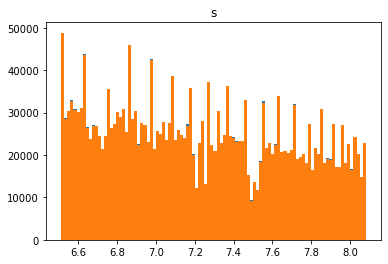

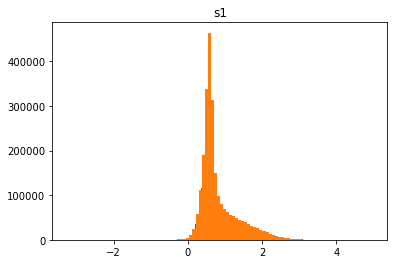

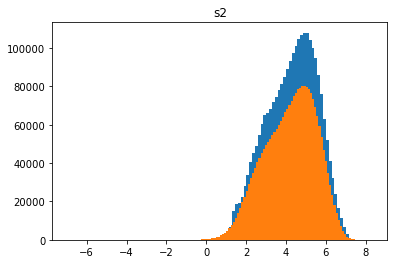

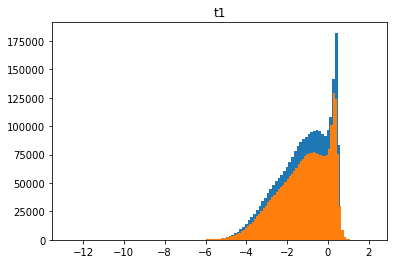

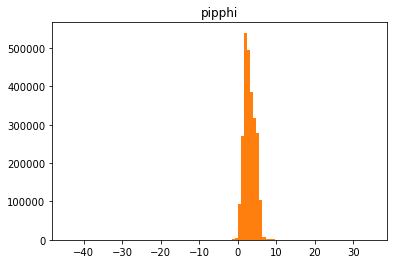

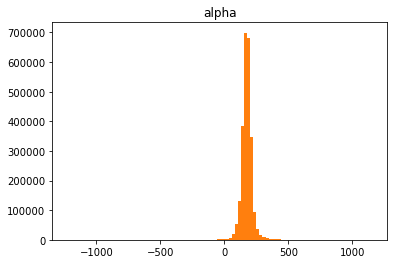

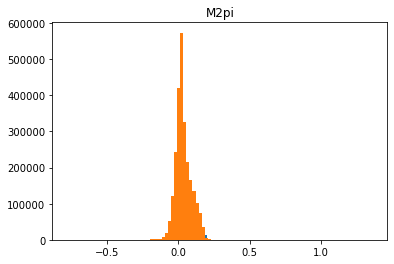

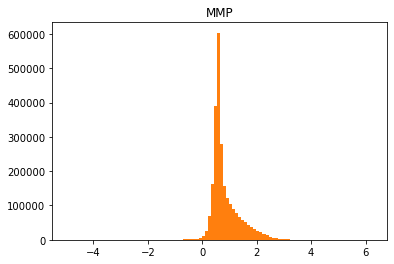

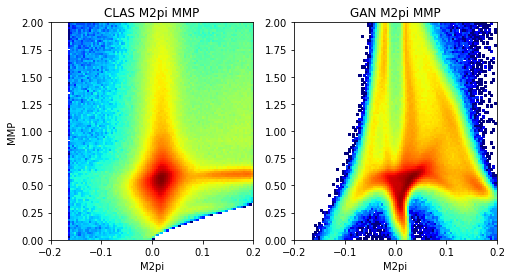

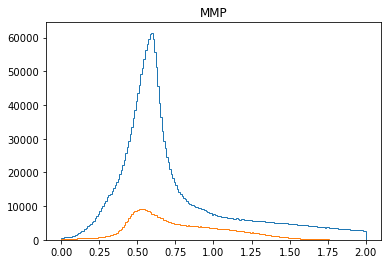

In [64]:
for epoch in range(5300, 5301):
       
    np.random.shuffle(clas)
    # print("Number of batches: ", int(dataset.shape[0] // BATCH_SIZE))
    discriminator_loss = []
    generator_loss = []
    minibatches_size = BATCH_SIZE * TRAINING_RATIO
    for i in range(int(clas.shape[0] // (BATCH_SIZE * TRAINING_RATIO))):
        discriminator_minibatches = clas[i * minibatches_size:
                                            (i + 1) * minibatches_size]

        noise= np.random.normal(0, 1, [BATCH_SIZE*TRAINING_RATIO, 100])
        s = gamma_dist_rand(BATCH_SIZE*TRAINING_RATIO)
        s = (s - gammamean)/gammastd
        
        for j in range(TRAINING_RATIO):         
            image_batch = discriminator_minibatches[j * BATCH_SIZE:
                                                    (j + 1) * BATCH_SIZE]
            noise_batch = noise[j * BATCH_SIZE:
                                                    (j + 1) * BATCH_SIZE]
            s_batch = s[j * BATCH_SIZE:
                                                    (j + 1) * BATCH_SIZE]
            discriminator_loss.append(discriminator_model.train_on_batch(
                [image_batch, s_batch, noise_batch],
                [positive_y, negative_y, dummy_y]))

        noise= np.random.normal(0, 1, [BATCH_SIZE, 100])
        s = gamma_dist_rand(BATCH_SIZE)
        s = (s - gammamean)/gammastd
        generator_loss.append(generator_model.train_on_batch([s, noise],
                                                             [positive_y, image_batch]))
        
    print(epoch, generator_loss)

    if epoch%100==0:
        print(epoch)
        SAMPLE_SIZE = events.shape[0]
        noise= np.random.normal(0, 1, [SAMPLE_SIZE, 100])
        s = gamma_dist_rand(SAMPLE_SIZE)
        s = (s - gammamean)/gammastd
        results = generator.predict([s, noise], batch_size = BATCH_SIZE)
        results = results*classtd+clasmean
        s = results[:, 0]
        s1 = results[:, 1]
        s2 = results[:, 2]
        t1 = results[:, 3]
        pipphi = results[:, 4]
        alpha = results[:, 5]
        m2pi = results[:,6]
        mpx2 = results[:,7]
        ganevents = np.stack([s, s1, s2, t1, pipphi, alpha, m2pi, mpx2], axis = 1)
        
        plt.hist(clas_origin[:, 0], bins=100 )#, range=[0, 10], histtype='step')
        plt.hist(ganevents[:, 0], bins=100 )#, range=[0, 10], histtype='step')
        plt.title("s")
        plt.show()
        
        plt.hist(clas_origin[:, 1], bins=100 )#, range=[-6, 0], histtype='step')
        plt.hist(ganevents[:, 1], bins=100 )#, range=[-6, 0], histtype='step')
        plt.title("s1")
        plt.show()
        
        plt.hist(clas_origin[:, 2], bins=100 )#, range=[-4, 0], histtype='step')
        plt.hist(ganevents[:, 2], bins=100 )#, range=[-4, 0], histtype='step')
        plt.title("s2")
        plt.show()
        
        plt.hist(clas_origin[:, 3], bins=100 )#, range=[-6, 1], histtype='step')
        plt.hist(ganevents[:, 3], bins=100 )#, range=[-6, 1], histtype='step')
        plt.title("t1")
        plt.show()
        
        plt.hist(clas_origin[:, 4], bins=100 )#, range=[-4, 1], histtype='step')
        plt.hist(ganevents[:, 4], bins=100 )#, range=[-4, 1], histtype='step')
        plt.title("pipphi")
        plt.show()
        
        plt.hist(clas_origin[:, 5], bins=100 )#, range=[1, 7], histtype='step')
        plt.hist(ganevents[:, 5], bins=100 )#, range=[1, 7], histtype='step')
        plt.title("alpha")
        plt.show()
        
        plt.hist(clas_origin[:, 6], bins=100 )#, range=[-0.3, 0.3], histtype='step')
        plt.hist(ganevents[:, 6], bins=100 )#, range=[-0.3, 0.3], histtype='step')
        plt.title("M2pi")
        plt.show()

        plt.hist(clas_origin[:, 7], bins=100 )#, range=[0, 2], histtype='step')
        plt.hist(ganevents[:, 7], bins=100 )#, range=[0, 2], histtype='step')
        plt.title("MMP")
        plt.show()


        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        plt.hist2d(clas_origin[:, 6], clas_origin[:, 7], bins= (100, 100), range=[[-0.2, 0.2], [0, 2]], cmap='jet', norm=mcol.LogNorm())
        plt.xlabel("M2pi")
        plt.ylabel("MMP")
        plt.title("CLAS M2pi MMP")
        plt.subplot(1, 2, 2)
        plt.hist2d(ganevents[:, 6], ganevents[:, 7], bins= (100, 100), range=[[-0.2, 0.2], [0, 2]], cmap='jet', norm=mcol.LogNorm())
        plt.xlabel("M2pi")
        plt.title("GAN M2pi MMP")
        plt.show()
        
        index = np.where(ganevents[:, 6]>0.08)
        ganMMP_cut = mpx2[index]
        plt.hist(MMP_cut, bins=200, range=[0, 2], histtype='step')
        plt.hist(ganMMP_cut, bins=200, range=[0, 2], histtype='step')
        plt.title("MMP")
        plt.show()
        
        generator.save_weights(imagedir+"generatorfilter"+str(epoch//100).zfill(5)+".h5")
        discriminator.save_weights(imagedir+"discriminatorfilter"+str(epoch//100).zfill(5)+".h5")
        
        np.save("clasfilter%d.npy"%(epoch//100), ganevents)

/home/pawel/Extras/anaconda3/envs/jlabML/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until


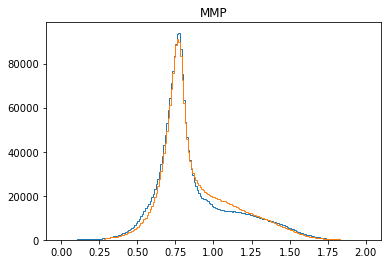

In [65]:
index = np.where(ganevents[:, 7]>0.08)
ganMMP_cut = mpx2[index]
plt.hist(np.sqrt(MMP_cut), bins=200, range=[0, 2], histtype='step')
plt.hist(np.sqrt(ganMMP_cut), bins=200, range=[0, 2], histtype='step')
plt.title("MMP")
plt.show()

In [ ]:
MMP

In [ ]:
M2PI

In [58]:
generator.load_weights("generatorfilter00001.h5")
discriminator.load_weights("discriminatorfilter00001.h5")

In [ ]:
def detector_filter_gamma(n, gamma_c):
    
    SAMPLE_SIZE = int(1.5*n)

    noise = np.random.normal(0, 1, [SAMPLE_SIZE, 100])
    gamma = gamma_dist_rand(SAMPLE_SIZE)
#     gamma = np.full((SAMPLE_SIZE, 1), gamma_c)
    gamma = (gamma - gammamean)/gammastd
    results_origin = generator.predict([gamma, noise], batch_size=BATCH_SIZE)
    ppipxy = results_origin[:, [1, 2, 4, 5]]
    ppipxy = ppipxy*ppipxystd+ppipxymean

    ptheta = np.arctan2(ppipxy[:, 1], ppipxy[:, 0])
    ptheta = ptheta.reshape(-1, 1)
    piptheta = np.arctan2(ppipxy[:, 3], ppipxy[:, 2])
    piptheta = piptheta.reshape(-1, 1)
    theta = np.concatenate([ptheta, piptheta], axis=1)
    theta = np.floor(theta/np.pi*180+205)%60

    index = np.where((theta[:, 0]<=50)&(theta[:, 1]<=50))

    noise = noise[index]
    results_origin = results_origin[index]
    return noise[:n], results_origin[:n]

In [ ]:
SAMPLE_SIZE = events.shape[0]
#         noise= np.random.normal(0, 1, [SAMPLE_SIZE, 100])
noise, results = detector_filter_gamma(SAMPLE_SIZE, 3.0)
#         results = generator.predict(noise)
results = results*classtd+clasmean

M2pi = results[:, 13]
gamma = results[:, 0]
px = results[:, 1]
py = results[:, 2]
pz = results[:, 3]
#         px = cbrtpx*cbrtpx*cbrtpx
#         py = cbrtpy*cbrtpy*cbrtpy
#         pz = cbrtpz*cbrtpz*cbrtpz
pe = results[:, 10]
pipx = results[:, 4]
#         cbrtpipy = results[:, 6]
pipy = results[:, 5]
pipz = results[:, 6]
#         pipx = cbrtpipx*cbrtpipx*cbrtpipx
#         pipy = cbrtpipy*cbrtpipy*cbrtpipy
#         pipz = cbrtpipz*cbrtpipz*cbrtpipz
pipe = results[:, 11]
pimx = results[:, 7]
pimy = results[:, 8]
pimz = results[:, 9]
pime = results[:, 12]


ganevents = np.stack([M2pi, gamma, px, pipx, pimx, py, pipy, pimy, pz, pipz, pimz, pe, pipe, pime], axis=1)
np.save("clasfiltercond.npy", ganevents)

In [ ]:
SAMPLE_SIZE = events.shape[0]*10
noise= np.random.normal(0, 1, [SAMPLE_SIZE, 100])
gamma = np.full((SAMPLE_SIZE, 1), 3.0)

In [ ]:
noise.shape

In [ ]:
gamma.shape

In [ ]:
SAMPLE_SIZE = events.shape[0]
noise= np.random.normal(0, 1, [SAMPLE_SIZE, 100])
# gamma = np.full((SAMPLE_SIZE, 1), 2.0)
gamma = gamma_dist_rand(SAMPLE_SIZE)
gamma = (gamma - gammamean)/gammastd
results = generator.predict([gamma, noise], batch_size=BATCH_SIZE)
results = results*classtd+clasmean

M2pi = results[:, 13]
gamma = results[:, 0]
px = results[:, 1]
py = results[:, 2]
pz = results[:, 3]
#         px = cbrtpx*cbrtpx*cbrtpx
#         py = cbrtpy*cbrtpy*cbrtpy
#         pz = cbrtpz*cbrtpz*cbrtpz
pe = results[:, 10]
pipx = results[:, 4]
#         cbrtpipy = results[:, 6]
pipy = results[:, 5]
pipz = results[:, 6]
#         pipx = cbrtpipx*cbrtpipx*cbrtpipx
#         pipy = cbrtpipy*cbrtpipy*cbrtpipy
#         pipz = cbrtpipz*cbrtpipz*cbrtpipz
pipe = results[:, 11]
pimx = results[:, 7]
pimy = results[:, 8]
pimz = results[:, 9]
pime = results[:, 12]


ganevents = np.stack([M2pi, gamma, px, pipx, pimx, py, pipy, pimy, pz, pipz, pimz, pe, pipe, pime], axis=1)
np.save("clasfiltercond_unfold.npy", ganevents)